In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src')

import pandas as pd
pd.set_option('display.max_rows', 100)


from datetime import timedelta

from sales_project.models.constant import ConstantModel
from sales_project.utils.plotters import linear_plot

In [2]:
# Reading data
df_daily = pd.read_csv("../data/data.csv").rename(
    columns={"item_cnt_day": "n_items"}
).drop("date_block_num", axis=1)
df_daily['timestamp'] = pd.to_datetime(df_daily['timestamp'])
items = pd.read_csv('../data/raw/items.csv')[['item_id', 'item_category_id']]


# Adding month related timestamp
df_daily['month_timestamp'] = df_daily['timestamp'].dt.to_period('M')

# Adding item_category_id column by merging
df_daily = df_daily.merge(items, on="item_id")

df_daily.head()

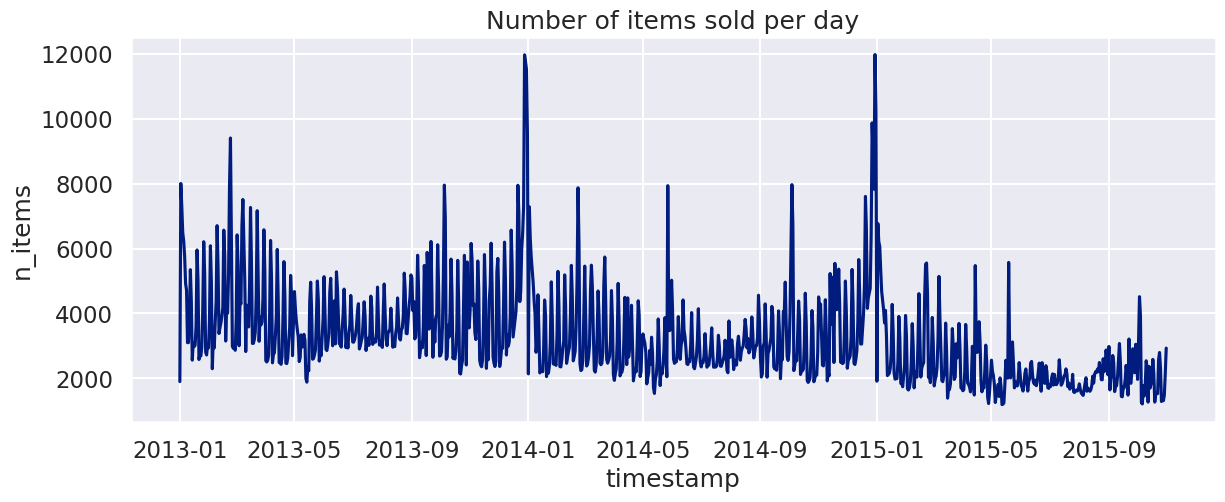

In [12]:
df_daily_grouped = df_daily.groupby(["timestamp"]).agg({"n_items": 'sum'}).reset_index()
linear_plot(data=df_daily_grouped, x='timestamp', y='n_items', title='Number of items sold per day')

In [13]:
# Let's consider last 3 month of data as a test data for all models
# In that case all seasonalities will be presented in both splits

split_timestamp = df_daily['timestamp'].max() - timedelta(days=90)

df_daily_train = df_daily[df_daily['timestamp'] <= split_timestamp]
df_daily_test = df_daily[df_daily['timestamp'] > split_timestamp]
print(f"Train data shape: {df_daily_train.shape}")
print(f"Test data shape: {df_daily_test.shape}")
print(f"Ratio of train data: {df_daily_train.shape[0] / df_daily.shape[0]}")
print(f"Ratio of test data: {df_daily_test.shape[0] / df_daily.shape[0]}")

Train data shape: (2701173, 7)
Test data shape: (152639, 7)
Ratio of train data: 0.9465139960165561
Ratio of test data: 0.0534860039834439


In [14]:
# Grouping data by month, shop, item - for models based on month-based timestamp
df_monthly = (
    df_daily.groupby(["month_timestamp", "item_id", "shop_id"])
    .agg({"n_items": "sum"})
    .reset_index()
    .merge(items, on="item_id")
)

df_monthly_train = (
    df_daily_train.groupby(["month_timestamp", "item_id", "shop_id"])
    .agg({"n_items": "sum"})
    .reset_index()
    .merge(items, on="item_id")
)

df_monthly_test = (
    df_daily_test.groupby(["month_timestamp", "item_id", "shop_id"])
    .agg({"n_items": "sum"})
    .reset_index()
    .merge(items, on="item_id")
)

In [15]:
df_monthly_train.head()

,month_timestamp,item_id,shop_id,n_items,item_category_id
0,2013-01,27,1,1.0,19
1,2013-01,27,2,1.0,19
2,2013-01,27,10,1.0,19
3,2013-01,27,19,1.0,19
4,2013-01,27,26,1.0,19


In [16]:
df_monthly_test.head()

,month_timestamp,item_id,shop_id,n_items,item_category_id
0,2015-08,30,5,1.0,40
1,2015-08,30,14,1.0,40
2,2015-08,30,26,1.0,40
3,2015-08,30,28,1.0,40
4,2015-08,30,44,1.0,40


# Constant Model. Kaggle Score: 7.25558

$C_t$ - number of sold items at month block $t$  
$C_t^{s}$ - number of sold items at month block $t$ for shop $a$  
$C_t^{i}$ - number of sold items at month block $t$ for item $b$  
$C_t^{c}$ - number of sold items at month block $t$ for item_category $c$  
$C_t^{s,i}$ - number of sold items at month block $t$ for shop $a$ and item $b$  
$C_t^{s,c}$ - number of sold items at month block $t$ for shop $a$ and item_category $c$  
$\tilde{C}_t^{s,i}$ - predicted number of sold items at month block $t+1$ for shop $a$ and item $b$ 


There are several options of how to apporach with a constant prediction:
  
$\quad \tilde{C}_{t+1}^{s,i} = \{C_{s}, C_t^{i}, C_t^{b}, C_t^{c}, C_t^{s,i}, C_t^{s,c}\} $  

In case of no last month data for $t+1$, the last existed month data is used for prediction.

In [23]:
model = ConstantModel()
res_train = model.evaluate(
    df=df_monthly_train,
    target_col="n_items",
    timestamp_col="month_timestamp",
    groups=[
        [],
        ["shop_id"],
        ["item_id"],
        ["item_category_id"],
        ["shop_id", "item_id"],
        ["shop_id", "item_category_id"],
    ],
)
res_train.sort_values('averaging')

  0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,MAPE,SMAPE,averaging,group
1,1.564208,23.353256,4.832521,0.000248,0.859207,61.938935,mean,[]
3,1.552175,22.894418,4.784811,0.009541,0.845523,60.311775,mean,['shop_id']
5,1.132975,14.686883,3.832347,0.001583,0.568177,38.721584,mean,['item_id']
7,1.466345,21.514496,4.638372,0.078530,0.768540,54.187544,mean,['item_category_id']
9,1.255076,21.338524,4.619364,-0.262832,0.567060,36.205730,mean,"['shop_id', 'item_id']"
11,1.413382,21.214741,4.605946,0.082011,0.724010,49.993390,mean,"['shop_id', 'item_category_id']"
0,1.146367,24.673205,4.967213,-0.056259,0.217363,33.284643,median,[]
2,1.141213,24.306641,4.930177,-0.051555,0.225514,33.377466,median,['shop_id']
4,0.936237,13.459972,3.668783,0.084988,0.349433,29.877357,median,['item_id']
6,1.112027,22.641501,4.758309,0.030260,0.265697,32.902121,median,['item_category_id']


In [24]:
res_test = model.evaluate(
    df=df_monthly_test,
    target_col="n_items",
    timestamp_col="month_timestamp",
    groups=[
        [],
        ["shop_id"],
        ["item_id"],
        ["item_category_id"],
        ["shop_id", "item_id"],
        ["shop_id", "item_category_id"],
    ],
)
res_test.sort_values('averaging')

  0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,MAPE,SMAPE,averaging,group
1,1.586360,82.938147,9.107038,-0.001169,0.820373,60.404424,mean,[]
3,1.539869,81.396230,9.021986,-0.000837,0.813916,56.775156,mean,['shop_id']
5,1.136365,69.831722,8.356538,0.186315,0.519535,37.782490,mean,['item_id']
7,1.397577,71.715833,8.468520,0.134469,0.642691,49.776020,mean,['item_category_id']
9,1.592387,124.896707,11.175720,0.179467,0.630156,40.867471,mean,"['shop_id', 'item_id']"
11,1.291987,68.761896,8.292279,0.157623,0.606433,45.292074,mean,"['shop_id', 'item_category_id']"
0,1.160740,84.188645,9.175437,-0.016264,0.202170,30.800760,median,[]
2,1.095129,82.358610,9.075164,-0.012670,0.200558,30.080160,median,['shop_id']
4,0.975143,69.596307,8.342440,0.189058,0.321935,29.032325,median,['item_id']
6,1.128227,76.263972,8.732925,0.079578,0.241325,30.876694,median,['item_category_id']


For training set:  
1. The best results showed a constant model based on $C_t^{i}$, which is not surprise  
since the number of items sold depends on that item  
2. Though the task is to predict items sold for different item and shop, $C_t^{s,i}$ is far  
from the best constant option

For testing set:  
1. The best results showed a constant model based on $C_t^{i}$ and $C_t^{i,c}$, unlike  
in the training data case

To conclude, the better option is to consider $C_t^{i}$  

Let's predict the sales for the submission set using the constant model based on $C_t^{i}$

In [75]:
# Retrieving last stored data about sales for each item
df_monthly['max_month_timestamp'] = df_monthly.groupby(['item_id'])['month_timestamp'].transform('max')
result_df = df_monthly.drop_duplicates(subset=['max_month_timestamp', 'item_id'])
result_df = result_df[['item_id', 'n_items', 'item_category_id']]

# Reading submission data
test_submission = pd.read_csv('../data/raw/test.csv')

# Predicting using last stored data (by merging)
test_submission2 = test_submission.merge(result_df[['item_id', 'n_items']], on=['item_id'], how='left')

test_submission2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ID       214200 non-null  int64  
 1   shop_id  214200 non-null  int64  
 2   item_id  214200 non-null  int64  
 3   n_items  197442 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 6.5 MB


There are missing values in the 'n_items' column. Let's fill them with the mean number of items sold for a corresponding item category

In [76]:
test_submission2 =  test_submission2.merge(items, on=['item_id'], how='left')

result_df2 = result_df.groupby('item_category_id').agg({'n_items': 'mean'}).reset_index()

test_submission2 = test_submission2.merge(result_df2, on=['item_category_id'], how='left')

test_submission2['item_cnt_month'] = test_submission2.apply(lambda x: x['n_items_x'] if not np.isnan(x['n_items_x']) else x['n_items_y'], axis=1)

#test_submission2 = test_submission2[['ID', 'item_cnt_month']]

test_submission2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                214200 non-null  int64  
 1   shop_id           214200 non-null  int64  
 2   item_id           214200 non-null  int64  
 3   n_items_x         197442 non-null  float64
 4   item_category_id  214200 non-null  int64  
 5   n_items_y         214158 non-null  float64
 6   item_cnt_month    214158 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 11.4 MB


In [77]:
test_submission2[test_submission2['item_cnt_month'].isnull()]

,ID,shop_id,item_id,n_items_x,item_category_id,n_items_y,item_cnt_month
460,460,5,20949,NaN,71,NaN,NaN
5560,5560,4,20949,NaN,71,NaN,NaN
10660,10660,6,20949,NaN,71,NaN,NaN
15760,15760,3,20949,NaN,71,NaN,NaN
20860,20860,2,20949,NaN,71,NaN,NaN
25960,25960,7,20949,NaN,71,NaN,NaN
31060,31060,10,20949,NaN,71,NaN,NaN
36160,36160,12,20949,NaN,71,NaN,NaN
41260,41260,28,20949,NaN,71,NaN,NaN
46360,46360,31,20949,NaN,71,NaN,NaN


There is one item left with no prediction  
Let's fill in the misssing data with a median value

In [78]:
test_submission2.loc[test_submission2['item_cnt_month'].isnull(), 'item_cnt_month'] = test_submission2['item_cnt_month'].median()

In [82]:
test_submission2 = test_submission2[['ID', 'item_cnt_month']]
test_submission2.to_csv('../data/predictions/constant.csv', index=False)